## Import Dependencies

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import transformers
import torch
import shap
import scipy as sp
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt

d:\MyApps\Anaconda\envs\nle\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
d:\MyApps\Anaconda\envs\nle\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_si

## Load Dataset

Movie Review

In [2]:
import os
import sys
sys.path.append('../')
df = pd.read_csv("../data/cos-e/parsed-cose-train.csv")

In [38]:
df.head()

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...
3,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...",pretty flowers.,hen house,natural habitat,storybook,dense forest,2,Usually the habitat of a fox is forest and it ...
4,e8a8b3a2061aa0e6d7c6b522e9612824,What home entertainment equipment requires cable?,radio shack,substation,cabinet,television,desk,3,television is the only option that is a home e...


## Get Explanations and SHAP score

### GPT explanation

In [3]:
# imports
import os
import ast  # for converting embeddings saved as strings back to arrays
import openai  
import pandas as pd
import tiktoken  # for counting tokens
from tqdm.auto import tqdm
from scipy import spatial  # for calculating vector similarities for search
openai.api_key = os.environ["OPENAI_API_KEY"]

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
# GPT_MODEL = "gpt-3.5-turbo-16k-0613"
GPT_MODEL = "gpt-4-0613" # According to OpenAI, GPT-4 is more responsive to system messages, whereas 3.5 would rely on more of the user input.


### Get NLE

In [5]:
# an example nle question

def prediction_function(input_premise, input_choices, input_label):

    query = []
    # print(len(input_premise))
    for i in range(len(input_premise)):
        x, s, y =  input_premise[i], input_choices[i], input_label[i]
        query.append(f">>>Question {i}: {x}\n>>>The choices are {s}\n>>>The correct choice is '{y}'\n---\n")
    query = "".join(query)
    n_reviews = len(input_premise)
    # print(query)
    sys_msg = f"""
    Given the following questions and their corresponding answer choices, please explain a possible reason for making this choices out of 5 choices.
    Note: 
    1. Treat each question independently. The start of an question is marked by ">>>Question i: ", where i is the number. 
    2. The answer choices for each question marked by ">>>The available choices are" and the correct choice is marked by ">>>The correct choice is". 
    3. Different quesiton instances are seperated by "---".
    
    Reply in the following format: 
    The reply to each review contains 2 lines.
    The first line is your explanation. (Please do not use any special character)
    The second line is a seperator "---" marking the end of the reply.
    There should be no new line between consecutive replies.
    
    The followings are examples of a valid response that contains 4 replies, followed by 4 lines of "---":
    your explanation
    ---
    your explanation
    ---
    your explanation
    ---
    your explanation
    ---
    """

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': sys_msg},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0,
    )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError

    model_nle_list = []
    model_response += '\n'
    # print(model_response)
    for line in model_response.split("\n---\n")[:-1]:
        try:
            model_nle = line.split('\n')
            model_nle_list.append(model_nle)
        except:
            print(">>>>>>>>>>>>Exception: model reply in wrong format for one reply")
            print(query)
            print(model_response)
            raise AssertionError
    return model_nle_list

def create_choices(sample_df):
    return [str([f"{cx+1}. "+sample[f"choice_{cx}"] for cx in range(5)]) for _,sample in sample_df.iterrows()]

def make_choice(sample_df):
    return [sample[f"choice_{sample['label']}"] for _,sample in sample_df.iterrows()]

In [10]:
import time
# sample_size = 320 
# sample_df = df.sample(sample_size).copy().reset_index(drop=True)
# sample_df = df.copy()
# sample_df['nle'] = None

sample_df = pd.read_csv('../COS-E_7191_7176_nle.csv')
sample_size = len(sample_df)
batch_size = 8
for i in tqdm(range(7176+8, len(sample_df), batch_size)):
    if i % batch_size*10 == batch_size*9: time.sleep(30)
    s_range = range(i, min(i+batch_size, len(sample_df)-1))
    list_nle = prediction_function(sample_df.question[s_range].tolist(), create_choices(sample_df.loc[s_range]), make_choice(sample_df.loc[s_range]))
    sample_df.loc[s_range, 'nle'] = list_nle
    sample_df.to_csv(f'../COS-E_{sample_size}_{i}_nle.csv', index=False)
    time.sleep(10)


  0%|          | 0/1 [00:00<?, ?it/s]

## BERT pretrained on COSE

### Generate SHAP values 

In [11]:
from transformers import pipeline, ZeroShotClassificationPipeline
original_pipe = pipeline("zero-shot-classification",model="sileod/deberta-v3-base-tasksource-nli")

class ZeroShotModelPipeline(ZeroShotClassificationPipeline):
    # Overwrite the __call__ method
    labels = None
    def __call__(self, *args):
        out = super().__call__(args[0], self.labels)[0]
        # return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])] for out in outs]
        return [[{"label":x[0], "score": x[1]}  for x in zip(out["labels"], out["scores"])]]


model = original_pipe.model
tokenizer = original_pipe.tokenizer

model = ZeroShotModelPipeline(
    model=model, tokenizer=tokenizer, 
    device=torch.device("cuda:0"), return_all_scores=True,
)
text = ["one day I will see the world"]
candidate_labels = ['travel', 'cooking', 'fighting', 'x', 'y']
# text = ["one day I will see the world"]
# candidate_labels = ['travel', 'cooking', 'fighting']

# classifier(text, candidate_labels, topk=20)
model.labels = candidate_labels
model.model.config.label2id.update({v:k for k,v in enumerate(model.labels)})
model.model.config.id2label.update({k:v for k,v in enumerate(model.labels)})
model(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EDAA138730> was reported to be 1 (when accessing len(dataloader)), but 2 samples have been fetched. 
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EDAA138730> was reported to be 1 (when accessing len(dataloader)), but 3 samples have been fetched. 
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EDAA138730> was reported to be 1 (when accessing len(dataloader)), but 4 samples have been fetched. 
Length of IterableDataset <transformers.pipelines.pt_utils.PipelineChunkIterator object at 0x000001EDAA138730> was reported to be 1 (when accessing len(dataloader)), but 5 samples have been fetched. 


[[{'label': 'y', 'score': 0.3937903046607971},
  {'label': 'travel', 'score': 0.3865874111652374},
  {'label': 'x', 'score': 0.20640937983989716},
  {'label': 'fighting', 'score': 0.008141872473061085},
  {'label': 'cooking', 'score': 0.005071044433861971}]]

In [19]:
str(range(0,3))

'range(0, 3)'

In [18]:
df.loc[range(0,3)]

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,max_shap_value
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,The correct choice is 'ignore' because the san...,0.171095
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,The correct choice is 'populated areas' becaus...,0.525636
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,The correct choice is 'atlas' because before t...,0.300299


In [ ]:
df = pd.read_csv('../COS-E_7191_7184_nle.csv')

import warnings
# warnings.resetwarnings()
warnings.filterwarnings("ignore")

top_k=3
for i, sample in tqdm(df.iterrows(), total=len(df)):
    candidate_labels = [sample[f'choice_{i}'] for i in range(5)]
    model.labels = candidate_labels
    model.model.config.label2id.update({v:k for k,v in enumerate(model.labels)})
    model.model.config.id2label.update({k:v for k,v in enumerate(model.labels)})
    explainer = shap.Explainer(model)
    shap_values = explainer([sample.question])

    instance = shap_values[0,:,sample[f"choice_{int(sample.label)}"]]
    pos_vals = instance.values[instance.values>0]
    max_n = np.argsort(pos_vals)[-top_k:]
    max_sum = pos_vals[max_n].sum()
    df.loc[i, f'max_shap_value'] = max_sum
    print(len(sample.question.split(" ")))
    print(max_sum)

df.to_csv('../COS-E_all_shap.csv', index=False)
# candidate_labels

In [13]:
sample_df.label

0      3
1      1
2      3
3      2
4      2
      ..
315    0
316    0
317    1
318    2
319    4
Name: label, Length: 320, dtype: int64

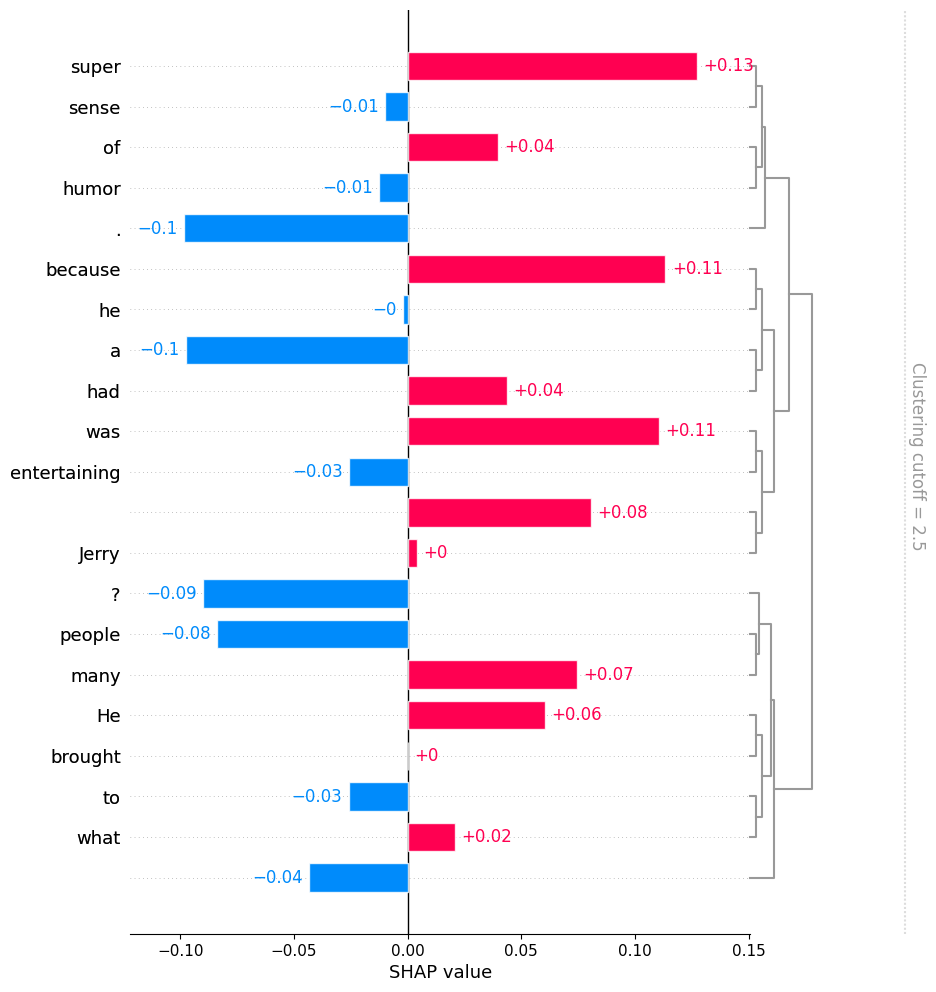

In [112]:
instance = shap_values[0,:,sample_df[f"choice_{sample_df.label[0]}"].values[0]]
# shap.plots.bar(instance, clustering_cutoff=1)
shap.plots.bar(instance, max_display=24, clustering_cutoff=2.5)

In [41]:
sample_df.review[9]

'susan granger \'s review of" session 9"( usa films) sometimes you just get more than your bargained for... \n like when boston- based hazmat elimination, run by scottish actor peter mullan and his trusty assistant, david caruso, assures a town engineer( paul guilifoyle) that they can remove insidious asbestos fibers from a victorian hospital facility in a week. \n erected in 1871, deserted and decomposing since 1985, the danvers mental hospital, is one of the most malevolent" locations" ever chosen for a film. \n the structure is so massive- with its labyrinth of rubble- strewn corridors, collapsing floors, stagnant pools of water, isolation cells, and ominous surgical chambers where experimental pre- frontal lobotomies were performed- that their task seems impossible within that time frame. \n and each member of their inexperienced crew( stephan gevedon, brandon sexton iii, and josh lucas) is coping with his own personal demons as, one by one, their minds seem to be affected by the g

In [42]:
sample_df.nle[9]

'The review is negative because the reviewer criticizes the movie for its lack of structure and not being scary. The reviewer also mentions that the conclusion is ludicrous and the movie overall is dark and gloomy.'

In [33]:
sample_df.label[9]

'negative'

In [30]:
sample_df = pd.read_csv('../movies_400_1600_nle.csv')
n = 10
sample_df[f'max_shap_value'] = None
for i in tqdm(range(len(shap_values))):
    # instance = shap_values[i,:,'POSITIVE']
    instance = shap_values[i,:,sample_df.label[i].upper()]
    pos_vals = instance.values[instance.values>0]
    max_n = np.argsort(pos_vals)[-n:]
    max_sum = pos_vals[max_n].sum()
    sample_df.loc[i, f'max_shap_value'] = max_sum

sample_df.to_csv('../movies_400_1600_nle_shap.csv', index=False)

  0%|          | 0/1600 [00:00<?, ?it/s]

### Explore Hierarchy

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [30.0, 30.0, 45.0, 45.0],
  [10.0, 10.0, 37.5, 37.5],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [80.0, 80.0, 95.0, 95.0],
  [60.0, 60.0, 87.5, 87.5],
  [23.75, 23.75, 73.75, 73.75],
  [105.0, 105.0, 115.0, 115.0],
  [110.0, 110.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [117.5, 117.5, 151.25, 151.25],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [192.5, 192.5, 222.5, 222.5],
  [134.375, 134.375, 207.5, 207.5],
  [48.75, 48.75, 170.9375, 170.9375]],
 'dcoord': [[0.0, 0.0707070707070707, 0.0707070707070707, 0.0],
  [0.0, 0.06060606060606061, 0.06060606060606061, 0.0],
  [0.06060606060606061, 0.14393939393939395, 0.14393939393939395, 0.0],
  [0.0707070707070707,
   0.21464646464646464,
   0.21464646464646464,
   0.1439393

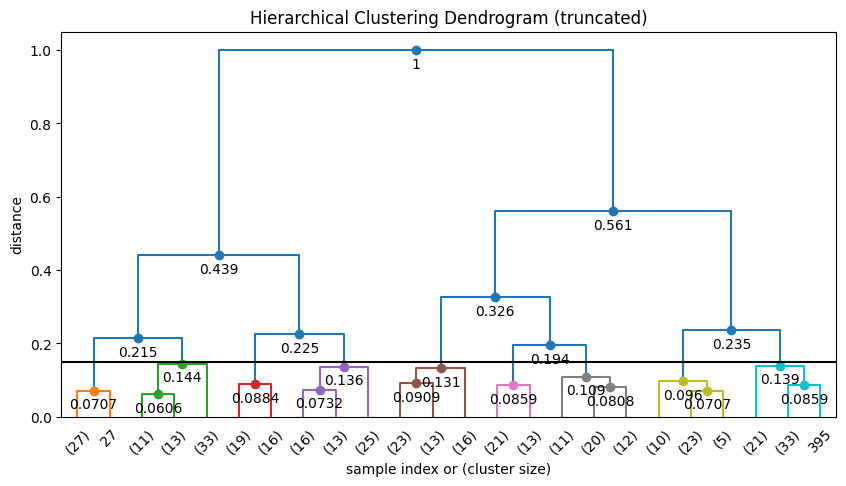

In [44]:
import matplotlib.pyplot as plt
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

plt.figure(figsize=(10, 5))
fancy_dendrogram(
    instance.clustering,
    truncate_mode='lastp',
    p=24,
    max_d=0.15,
)

## Training for the Probe

### Load Model

In [3]:
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
tokenizer = bert_model.tokenizer
sample_input = tokenizer(['heavy metal'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


### Get Data

In [ ]:
# get the content between brackets
def get_bracket_content(s):
    return re.findall(r'\((.*?)\)', s)[0]

In [22]:
import ast
import re
sample_df = None
supplements = ["../COS-E_range(0, 1797)_shap.csv", "../COS-E_range(1797, 3594)_shap.csv"]
final_df_len = 0
for fname in supplements:
    # range_tuple = re.findall(r'\((.*?)\)', fname)[0].split(', ')
    # range_tuple = [int(x) for x in range_tuple]
    if sample_df is None:
        sample_df = pd.read_csv(fname)
    else:
        sample_df = pd.concat([sample_df, pd.read_csv(fname)], ignore_index=True)  
sample_df

,id,question,choice_0,choice_1,choice_2,choice_3,choice_4,label,human_expl_open-ended,nle,max_shap_value
0,075e483d21c29a511267ef62bedc0461,The sanctions against the school were a punish...,ignore,enforce,authoritarian,yell at,avoid,0,Not sure what else could be a common ground,The correct choice is 'ignore' because the san...,0.138988
1,61fe6e879ff18686d7552425a36344c8,Sammy wanted to go to where the people were. ...,race track,populated areas,the desert,apartment,roadblock,1,People will be in populated areas.,The correct choice is 'populated areas' becaus...,0.524474
2,02e821a3e53cb320790950aab4489e85,Google Maps and other highway and street GPS s...,united states,mexico,countryside,atlas,oceans,3,atlases were collections of highway and street...,The correct choice is 'atlas' because before t...,0.299161
3,23505889b94e880c3e89cff4ba119860,"The fox walked from the city into the forest, ...",pretty flowers.,hen house,natural habitat,storybook,dense forest,2,Usually the habitat of a fox is forest and it ...,The correct choice is 'natural habitat' becaus...,0.308381
4,e8a8b3a2061aa0e6d7c6b522e9612824,What home entertainment equipment requires cable?,radio shack,substation,cabinet,television,desk,3,television is the only option that is a home e...,The correct choice is 'television' because tel...,0.581234
...,...,...,...,...,...,...,...,...,...,...,...
3589,a1eaeef3962f7568b3a27f5ebb897986,If someone is agreeing with everybody they're ...,like,problem,harmony,peace,joyful,1,One caught in the middle may be having a problem.,The correct choice is 'problem' because agreei...,0.316055
3590,dba5b709730a216f6b1be8ea703a8471,A wooden rod was used to wind up his freestand...,broom closet,old houses,carpentry shop,old clock,put a bar,3,Old Clock is the only item that requires winding,The correct choice is 'old clock' because wood...,0.213308
3591,a4f6192e01e371f5875098cb389112d8,"He was back in his hometown, he was planning o...",being understood,hug,rambling,kiss,visiting friends,4,"HomeTown - Shop online for Furniture, Home Dec...",The correct choice is 'visiting friends' becau...,0.245332
3592,898f20ed4a2f4e98c97fecbf87e8e70b,What do dogs need to be happy?,walked,guard house,affection,roll over,go outside,2,Dogs need lots of affection to be hapy,Dogs need affection to be happy. While walking...,0.533979


In [38]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial

device = torch.device('cuda:0')

## use a tokenizer from the bert model


class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=256, num_layers=3, bidirectional=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
        self.embedding = self.bert_model.model.distilbert.eval()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        out_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(out_size, 1)
        self.double()
    def forward(self, x):
        with torch.no_grad():
            bert_embeddings = self.embedding(**x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(bert_embeddings.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out
        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        return nle_input, label  

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = {k: v.to(device) for k, v in nle_input.items()}
    return nle_input, torch.tensor(label).to(device).reshape(-1,1)

model = LSTM_regressor().to('cuda')
tokenizer = model.bert_model.tokenizer
collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))

np.random.seed(42)
idxes = np.random.permutation(len(sample_df))

train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
    batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(len(train_dataset), len(val_dataset), len(test_dataset))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


2515 539 540


In [43]:
# best_val_loss = np.inf
best_peasonr = -np.inf
for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
    model.train()
    y_true, y_pred, train_loss = [], [], []
    for (xs, ys) in train_dataloader:
        model.zero_grad()
        out = model(xs)
        loss = criterion(out, ys)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        y_true.append(ys.detach().cpu().numpy().flatten())
        y_pred.append(out.detach().cpu().numpy().flatten())
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    train_loss = np.mean(train_loss)
    train_PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]

    model.eval()
    y_true, y_pred, val_loss = [], [], []
    for (xs, ys) in val_dataloader:
        with torch.no_grad():
            out = model(xs)
        y_true.append(ys.cpu().numpy().flatten())
        y_pred.append(out.cpu().numpy().flatten())
        loss = criterion(out, ys)
        val_loss.append(loss.item())
    val_loss = np.mean(val_loss)
    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
    print(f'epoch: {epoch}, train_loss {train_loss:.3f}, PearsonR: {train_PearsonR:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
    if PearsonR > best_peasonr:
        best_peasonr = PearsonR
        torch.save(model.state_dict(), 'best_model.pth')
        print('saved best model')

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0, train_loss 0.011, PearsonR: 0.134, val_loss: 0.010, PearsonR: 0.222
saved best model
epoch: 1, train_loss 0.010, PearsonR: 0.222, val_loss: 0.010, PearsonR: 0.224
saved best model
epoch: 2, train_loss 0.010, PearsonR: 0.237, val_loss: 0.010, PearsonR: 0.258
saved best model
epoch: 3, train_loss 0.010, PearsonR: 0.248, val_loss: 0.010, PearsonR: 0.272
saved best model
epoch: 4, train_loss 0.010, PearsonR: 0.270, val_loss: 0.011, PearsonR: 0.255
epoch: 5, train_loss 0.010, PearsonR: 0.253, val_loss: 0.010, PearsonR: 0.228
epoch: 6, train_loss 0.010, PearsonR: 0.287, val_loss: 0.010, PearsonR: 0.248
epoch: 7, train_loss 0.010, PearsonR: 0.300, val_loss: 0.011, PearsonR: 0.192
epoch: 8, train_loss 0.010, PearsonR: 0.312, val_loss: 0.011, PearsonR: 0.210
epoch: 9, train_loss 0.009, PearsonR: 0.341, val_loss: 0.010, PearsonR: 0.221
epoch: 10, train_loss 0.009, PearsonR: 0.361, val_loss: 0.012, PearsonR: 0.214
epoch: 11, train_loss 0.009, PearsonR: 0.346, val_loss: 0.011, PearsonR: 

In [45]:

datasets_dict = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

import ipywidgets as widgets
@widgets.interact(split=['train', 'val', 'test'])
def eval_for_datast(split):
    some_dataset = datasets_dict[split]
    some_dataloader = DataLoader(some_dataset,
        batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)
    y_pred, y_true, xs_len = [], [], []
    for (xs, ys) in (disc:=tqdm(some_dataloader)):
        with torch.no_grad():
            out = model(xs)
        y_pred.append(out.cpu().numpy())
        y_true.append(ys.cpu().numpy())
        # disc.set_description(f'loss: {loss.item():.3f}')
    y_pred = np.vstack(y_pred).flatten()
    y_true = np.vstack(y_true).flatten()
    MAE = np.abs(y_pred - y_true)
    sent_len = [len(x.split(" ")) for x in some_dataset.df.question]
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)
    Loss = criterion(torch.tensor(y_pred), torch.tensor(y_true)).item()
    print(f'PearsonR: {PearsonR[0]:.3f}, p-value: {PearsonR[1]:.3f}, loss: {Loss:.3f}')
    plt.scatter(y_pred, y_true, alpha=0.5)
    plt.show()  
    PearsonR = scipy.stats.pearsonr(sent_len, MAE)
    print(f'PearsonR: {PearsonR[0]:.3f}') 
    plt.scatter(sent_len, MAE, alpha=0.5)
    plt.show()
    @widgets.interact(idx=(0, len(some_dataset)-1))
    def show_sample(idx):
        x, y = some_dataset[idx]
        nle = tokenizer(x, return_tensors="pt", padding=True)
        nle = {k: v.to(device) for k, v in nle.items()}
        model.eval()
        with torch.no_grad():
            out = model(nle)
        # out, sample_df.max_shap_value[0]
        print(f'predicted: {out.item():.3f}, actual: {y:.3f}')
        print(f'input: {x}')


interactive(children=(Dropdown(description='split', options=('train', 'val', 'test'), value='train'), Output()…

In [53]:
out.shape

torch.Size([16, 1])